In [1]:
%cd CPMP-ML

g:\My Drive\PUCV\CPMP_With_attetion\CPMP-ML


##Librerias Necesarias

In [38]:
import numpy as np
import pandas as pd
import keras
from keras.layers import Input, Add, Dense, MultiHeadAttention, LayerNormalization, Dropout, Flatten
from keras.models import Model, load_model
from keras.utils import to_categorical
import cpmp_ml
import numpy as np
from cpmp_ml import generate_random_layout
import tensorflow as tf
from copy import deepcopy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
%cd ..

g:\My Drive\PUCV\CPMP_With_attetion


# Funciones necesarias

## Algoritmo Greedy y funciones para generación de datos

In [4]:
def is_valid_BG_move(layout, s_o, s_d):
    if (s_o != s_d  and len(layout.stacks[s_o]) > 0
    and  len(layout.stacks[s_d]) < layout.H
    and layout.is_sorted_stack(s_o)==False
    and layout.is_sorted_stack(s_d)==True
    and layout.gvalue(s_o) <= layout.gvalue(s_d)):
      return True

    else: return False

In [5]:
def select_bg_move(layout):
  bg_move = None
  S=len(layout.stacks)
  min_diff = 100
  for s_o in range(S):
     for s_d in range(S):
       if is_valid_BG_move(layout, s_o, s_d):
          diff = layout.gvalue(s_d) - layout.gvalue(s_o)
          if min_diff > diff:
            min_diff = diff
            bg_move = (s_o,s_d)
  return bg_move

In [6]:
def greedy(layout, basic=True):
    moves = []
    steps = 0
    while layout.unsorted_stacks>0:
        bg_move=select_bg_move(layout)
        if bg_move is not None:
            moves.append(bg_move)
            layout.move(bg_move)
        else:
            return -1, None # no lo resuelve
        steps +=1

    if layout.unsorted_stacks==0:
        return steps, moves
    return -1, None

In [7]:
def unlist(data,labels1, labels2, state, source, destination):
  n = len(source)
  for i in range(n):
    data.append(state[i])
    labels1.append(source[i])
    labels2.append(destination[i])

In [8]:
def get_ann_state(layout):
  S=len(layout.stacks)
  #matriz de stacks
  b = 2. * np.ones([S,layout.H + 1])
  for i,j in enumerate(layout.stacks):
     b[i][layout.H-len(j) + 1:] = [k/layout.total_elements for k in j]
     b[i][0] = layout.is_sorted_stack(i)
  b.shape=(S,(layout.H + 1))
  return b

#overriding the function in the module
cpmp_ml.get_ann_state = get_ann_state

In [9]:
def convert_label(score):
    list_score = []

    for i in score:
        list_score.append(i)

    return np.array(list_score)

In [10]:
def generate_steps_of_a_state(layout):
    states = [] # estados antes de movimiento
    source_tags = [] # etiquetas origen
    destination_tags = []  # etiquetas destino

    aux = deepcopy(layout)  # creación de copia de objeto

    steps, moves = greedy(aux)
    if steps == -1:
      return None, None, None

    for i in range(steps):
        states.append(get_ann_state(layout)) # antes del movimiento
        source_tags.append(convert_label(to_categorical(moves[i][0],len(layout.stacks))))
        destination_tags.append(convert_label(to_categorical(moves[i][1],len(layout.stacks))))
        layout.move(moves[i])
        aux = deepcopy(layout)

    return states, source_tags, destination_tags

In [11]:
def create_different_states(S, H, max_priority_container, n):
  data_state = []
  labels_source = []
  labels_destination = []
  iter = 0
  while iter < n:
    layout = generate_random_layout(S,H,max_priority_container)
    state, source, destination = generate_steps_of_a_state(layout)
    if state == None and source == None and destination == None: continue
    unlist(data_state,labels_source,labels_destination,state,source,destination)
    iter+=1

  return np.stack(data_state), np.stack(labels_source), np.stack(labels_destination)

## Funciones para entrenamiento y predicciones

In [12]:
def compare(predict, y_test):
    aciertos = 0
    size = len(predict)

    for i in range(size):
        max_1 = np.argmax(predict[i])
        max_2 = np.argmax(y_test[i])

        if max_1 == max_2:
            aciertos += 1

    return aciertos / size

In [13]:
def expand_dims_cpmp(data, labels, stacks, height):
    size = data.shape[1]
    tuple_data = zip(data, labels)
    data_2 = []
    labels_2 = []

    for matrix, label in tuple_data:
        matrix = matrix.tolist()
        label = label.tolist()
        for i in range(stacks - size):
            matrix.append([1] + [1 for n in range(height)])
            label.append(0)

        data_2.append(matrix)
        labels_2.append(label)

    return np.array(data_2), np.array(labels_2)

## Funciones para cargar y guardar data

In [14]:
def concatenate_state_with_output(states, outputs):
    size_stacks = len(states[0])
    size_height = len(states[0][0])
    tuple_data = zip(states, outputs)
    new_data = []

    for state, output in tuple_data:
        new_data.append([])

        for i in range(size_stacks):
            stack = state[i].tolist()
            stack.append(output[i])
            new_data[len(new_data) - 1].append(stack)

    return np.stack(new_data)

In [15]:
def save_data(data, labels_1, labels_2, name):
    size_stack = len(data[0])
    size_height = len(data[0][0])
    total_data = len(data)
    tuple_data = zip(data, labels_1, labels_2)

    with open(name + '.csv', 'w') as archivo:
        archivo.write('Total data: ' + str(total_data) + '\n')
        archivo.write('Stacks:' + str(size_stack) + ',Height:' + str(size_height) + '\n')
        archivo.write('\n')

        for matrix, label_1, label_2 in tuple_data:
            lista_stack = matrix.flatten()
            archivo.write('matrix:' + str(lista_stack.tolist())[1:-1] + '\n')
            archivo.write('label_1:' + str(label_1.tolist())[1:-1] + '\n')
            archivo.write('label_2:' + str(label_2.tolist())[1:-1] + '\n')
            archivo.write('\n')

        archivo.close()

In [16]:
def load_data(name):
    data = []
    labels_1 = []
    labels_2 = []

    with open(name + '.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_1 = archivo.readline().split(':')[1].split(',')
            label_1 = np.array(label_1, dtype= float)
            label_2 = archivo.readline().split(':')[1].split(',')
            label_2 = np.array(label_2, dtype= float)

            data.append(matrix)
            labels_1.append(label_1)
            labels_2.append(label_2)

            archivo.readline()

    return np.stack(data), np.stack(labels_1), np.stack(labels_2)

# Modelo de atención y clasificador de stacks

In [17]:
# Capa de normalización de datos
def normalization_layer(input, attention):
    layer = Add()([input,attention])
    layer = LayerNormalization(epsilon=1e-6)(layer)
    return layer

In [18]:
# Capa de feed-fordward, en el fondo es la parte entrenable
# que ayuda al modelo a darle caracteristicas a las entradas
def feed_forward_layer(input, num_neuron):
    # capa de feed para que el modelo pueda aprender
    layer = Dense(num_neuron,activation='sigmoid')(input)
    layer = Dense(num_neuron)(layer)
    return layer

In [19]:
# capa de atencion, al principio se probará con un cabezal,
# que corresponde calcular un scaled-dot-product-attention
def attention_layer(heads, d_model, reshape):
    attention = MultiHeadAttention(num_heads=heads, key_dim=d_model)(reshape,reshape)
    return attention

In [20]:
# Creacion de modelo de clasificación binaria con softmax
def stack_attention(heads, d_model, reshape, input):
    # por si se debe modificar la dimensión
    attention = attention_layer(heads,d_model,reshape)
    normalization = normalization_layer(input, attention)
    feed = feed_forward_layer(normalization, d_model)

    return feed

In [21]:
def create_model(heads, S, H , optimizer):
    input = Input(shape= (S, H+1))

    reshape = stack_attention(heads, H + 1, input, input)
    reshape = stack_attention(heads, H + 1, reshape, input)

    reshape = Flatten()(reshape)
    hidden1 = Dense(H*6, activation='sigmoid')(reshape)
    dropout_1 = Dropout(0.5)(hidden1)
    hidden2 = Dense(H*6, activation='sigmoid')(dropout_1)
    output = Dense(S,activation='softmax')(hidden2)

    model = Model(inputs=input,outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['mae', 'mse', 'accuracy'])

    return model

# Modelo Output (Con una sola salida)

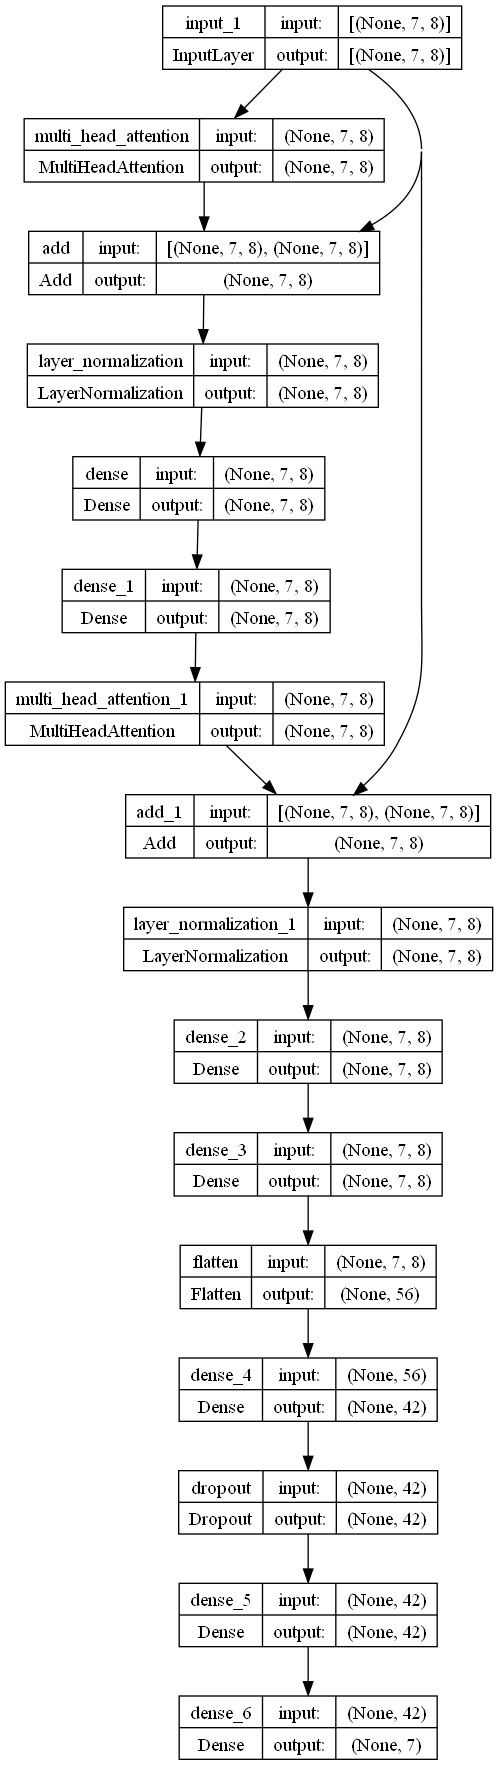

In [35]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model_cpmp_origin_5x5 = create_model(heads= 5, S= 5, H= 5, optimizer= optimizer)
keras.utils.plot_model(model_cpmp_origin, show_shapes=True, to_file= 'images_models/model_cpmp_origin_5x5.png')

# Generador de data

In [ ]:
# Cantidad de stacks
S = 5#@param {type:'slider',min:1,max:1000,steps:1}

# Altura de la bahía
H = 7#@param {type:'slider',min:1,max:1000,steps:1}

# Número máximo de prioridad
MPC = 32 #@param {type:'slider',min:1,max:1000,steps:1}

# Cantida casos de entrenamiento
N = 10000 #@param {type:'slider',min:1,max:100000,steps:1}

X_train, y_train_1, y_train_2 = create_different_states(S, H, MPC, N)

In [46]:
# Cantidad de stacks
S2 = 3 #@param {type:'slider',min:1,max:100,steps:1}

# Altura de la bahía
H2 = 7 #@param {type:'slider',min:1,max:100,steps:1}

# Número máximo de prioridad
MPC2 = 12 #@param {type:'slider',min:1,max:100,steps:1}

# Cantida casos de prueba
N2 = 500 #@param {type:'slider',min:1,max:10000,steps:1}

X_test, y_test_1, y_test_2 = create_different_states(S2, H2, MPC2, N2)

# Cargar Data

In [61]:
data_7x7, labels_1_7x7, labels_2_7x7 = load_data('data/data_7x7')

In [26]:
data_5x5, labels_1_5x5, labels_2_5x5 = load_data('data/data_5x5')

# Entrenamiento y pruebas

## Modelo 5x5

In [56]:
model_cpmp_origin_5x5 = load_model('models/model_cpmp_origin_5x5.h5')

In [58]:
X_train_5x5, X_test_5x5, y_train_1_5x5, y_test_1_5x5 = train_test_split(data_5x5, labels_1_5x5, test_size= 0.2, random_state= 42)

In [36]:
history = model_cpmp_origin_5x5.fit(X_train_5x5, y_train_1_5x5, batch_size= 32, epochs= 30)

Epoch 1/30
6224/6224 [==============================] - 32s 4ms/step - loss: 0.7068 - mae: 0.1636 - mse: 0.0787 - accuracy: 0.6946
Epoch 2/30
6224/6224 [==============================] - 28s 4ms/step - loss: 0.4595 - mae: 0.1145 - mse: 0.0560 - accuracy: 0.7714
Epoch 3/30
6224/6224 [==============================] - 28s 4ms/step - loss: 0.4159 - mae: 0.1046 - mse: 0.0516 - accuracy: 0.7875
Epoch 4/30
6224/6224 [==============================] - 29s 5ms/step - loss: 0.4009 - mae: 0.1007 - mse: 0.0498 - accuracy: 0.7949
Epoch 5/30
6224/6224 [==============================] - 28s 4ms/step - loss: 0.3867 - mae: 0.0973 - mse: 0.0482 - accuracy: 0.8021
Epoch 6/30
6224/6224 [==============================] - 28s 5ms/step - loss: 0.3702 - mae: 0.0931 - mse: 0.0460 - accuracy: 0.8142
Epoch 7/30
6224/6224 [==============================] - 28s 4ms/step - loss: 0.3415 - mae: 0.0853 - mse: 0.0421 - accuracy: 0.8359
Epoch 8/30
6224/6224 [==============================] - 30s 5ms/step - loss: 0.3115

Text(0.5, 0.98, 'Modelo CPMP origen 5x5')

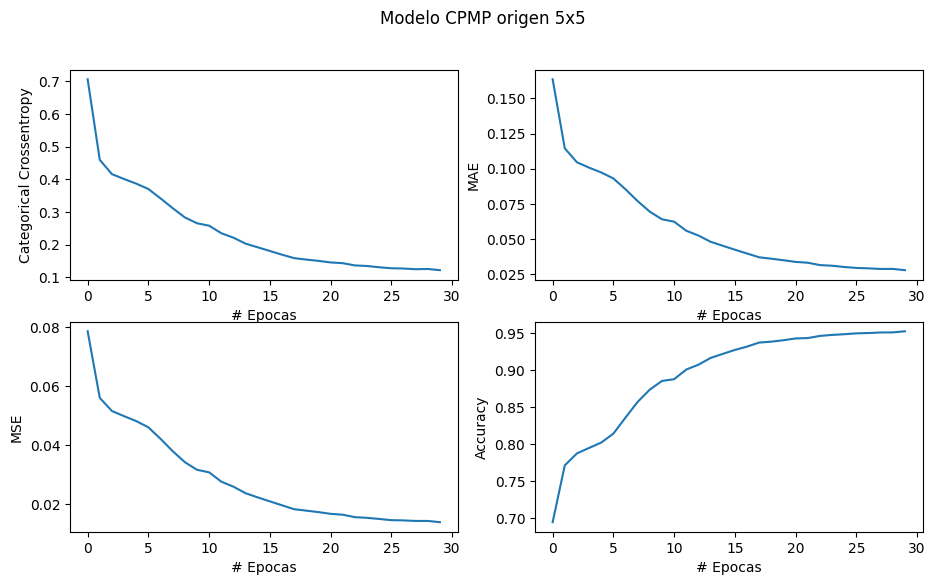

In [49]:
plt.figure(figsize=(11, 6)) 

plt.subplot(2,2,1)
plt.xlabel("# Epocas")
plt.ylabel("Categorical Crossentropy")
plt.plot(history.history["loss"])

plt.subplot(2,2,2)
plt.xlabel("# Epocas")
plt.ylabel("MAE")
plt.plot(history.history["mae"])

plt.subplot(2,2,3)
plt.xlabel("# Epocas")
plt.ylabel("MSE")
plt.plot(history.history["mse"])

plt.subplot(2,2,4)
plt.xlabel("# Epocas")
plt.ylabel("Accuracy")
plt.plot(history.history["accuracy"])

plt.suptitle("Modelo CPMP origen 5x5")


In [51]:
predict_5x5 = model_cpmp_origin_5x5.predict(X_test_5x5)

1556/1556 [==============================] - 4s 3ms/step


In [59]:
result = compare(predict_5x5, y_test_1_5x5)
print(f"Porcentaje de acierto: {round(result * 100, 2)}%")

Porcentaje de acierto: 94.81%


## Modelo 7x7

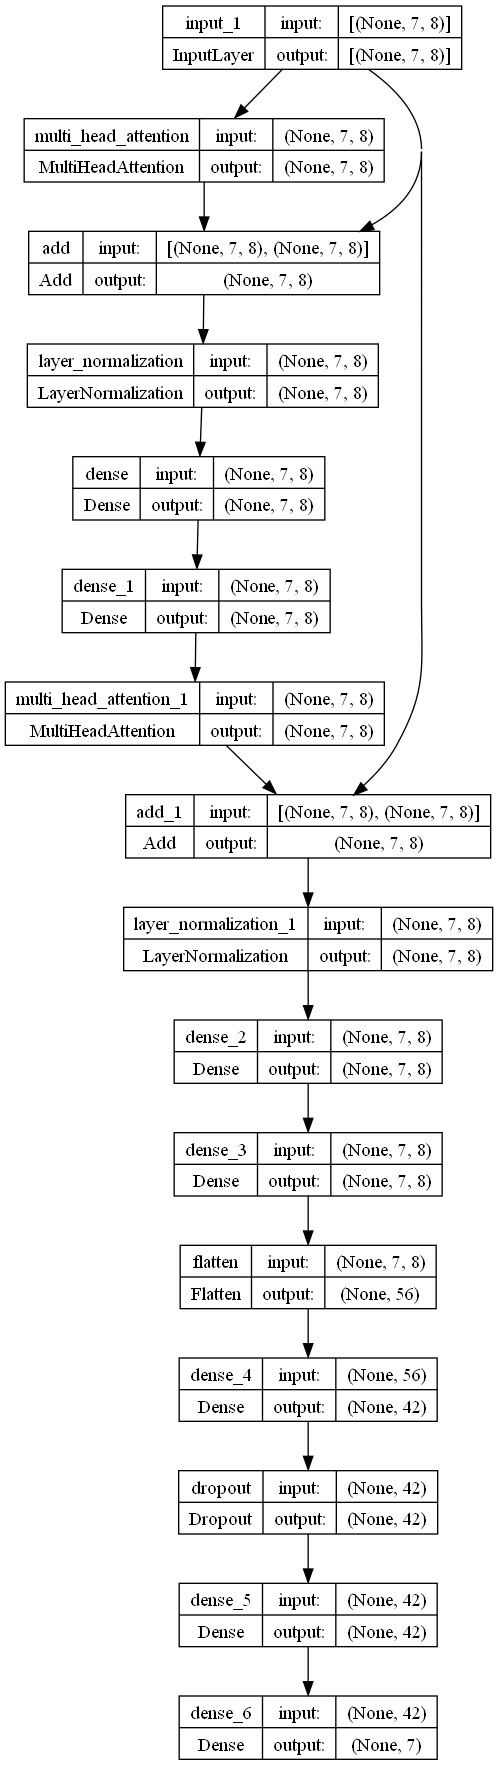

In [68]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model_cpmp_origin_7x7 = create_model(heads= 5, S= 7, H= 7, optimizer= optimizer)
keras.utils.plot_model(model_cpmp_origin, show_shapes=True, to_file= 'images_models/model_cpmp_origin_5x5.png')

In [64]:
X_train_7x7, X_test_7x7, y_train_1_7x7, y_test_1_7x7 = train_test_split(data_7x7, labels_1_7x7, test_size= 0.2, random_state= 42)

In [69]:
historial_7x7 = model_cpmp_origin_7x7.fit(X_train_7x7, y_train_1_7x7, batch_size= 32, epochs= 60)

Epoch 1/60
4244/4244 [==============================] - 17s 3ms/step - loss: 1.2244 - mae: 0.1790 - mse: 0.0879 - accuracy: 0.4915
Epoch 2/60
4244/4244 [==============================] - 14s 3ms/step - loss: 0.9562 - mae: 0.1524 - mse: 0.0752 - accuracy: 0.5457
Epoch 3/60
4244/4244 [==============================] - 14s 3ms/step - loss: 0.8484 - mae: 0.1391 - mse: 0.0688 - accuracy: 0.5906
Epoch 4/60
4244/4244 [==============================] - 14s 3ms/step - loss: 0.7822 - mae: 0.1293 - mse: 0.0641 - accuracy: 0.6301
Epoch 5/60
4244/4244 [==============================] - 14s 3ms/step - loss: 0.7363 - mae: 0.1217 - mse: 0.0603 - accuracy: 0.6603
Epoch 6/60
4244/4244 [==============================] - 14s 3ms/step - loss: 0.7057 - mae: 0.1167 - mse: 0.0579 - accuracy: 0.6778
Epoch 7/60
4244/4244 [==============================] - 14s 3ms/step - loss: 0.6787 - mae: 0.1123 - mse: 0.0558 - accuracy: 0.6906
Epoch 8/60
4244/4244 [==============================] - 15s 3ms/step - loss: 0.6491

Text(0.5, 0.98, 'Modelo CPMP origen 7x7')

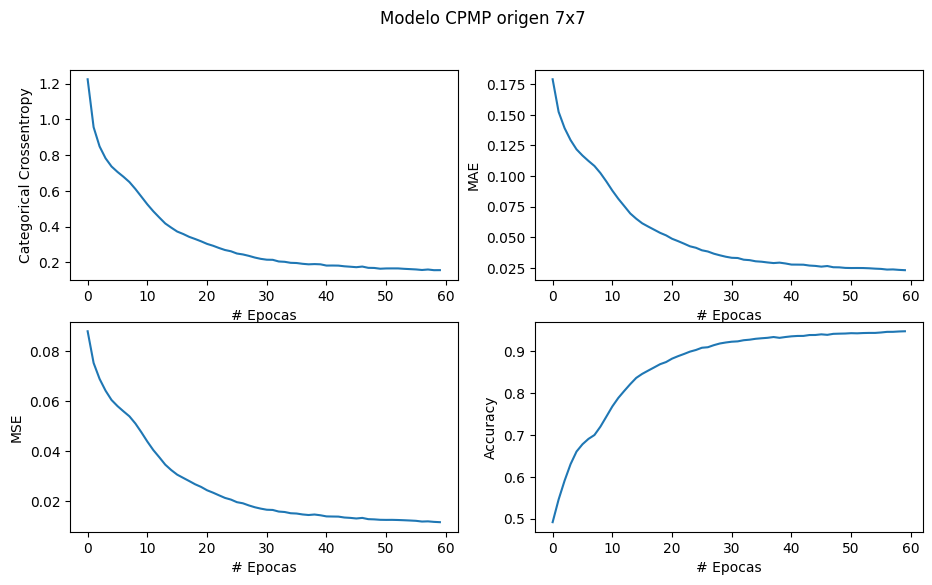

In [71]:
plt.figure(figsize=(11, 6)) 

plt.subplot(2,2,1)
plt.xlabel("# Epocas")
plt.ylabel("Categorical Crossentropy")
plt.plot(historial_7x7.history["loss"])

plt.subplot(2,2,2)
plt.xlabel("# Epocas")
plt.ylabel("MAE")
plt.plot(historial_7x7.history["mae"])

plt.subplot(2,2,3)
plt.xlabel("# Epocas")
plt.ylabel("MSE")
plt.plot(historial_7x7.history["mse"])

plt.subplot(2,2,4)
plt.xlabel("# Epocas")
plt.ylabel("Accuracy")
plt.plot(historial_7x7.history["accuracy"])

plt.suptitle("Modelo CPMP origen 7x7")

In [72]:
predict_7x7 = model_cpmp_origin_7x7.predict(X_test_7x7)

1061/1061 [==============================] - 2s 2ms/step


In [73]:
result = compare(predict_7x7, y_test_1_7x7)
print(f"Porcentaje de acierto: {round(result * 100, 2)}%")

Porcentaje de acierto: 95.66%


# Modelo Input (Con una sola salida)

In [75]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
model_cpmp_dest = create_model(heads= 5, S= 7, H= 7 + 1, optimizer= optimizer)

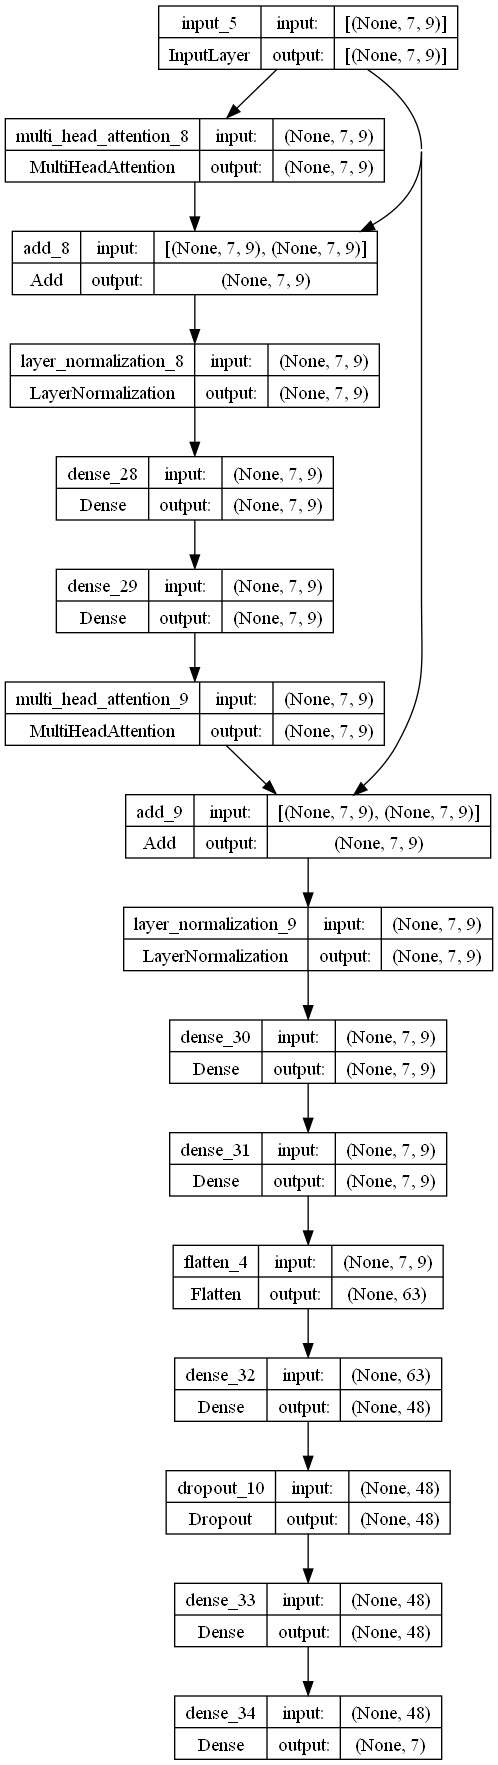

In [76]:
keras.utils.plot_model(model_cpmp_dest,show_shapes=True, to_file= 'images_models/model_cpmp_dest_7x7.png')

In [79]:
X_train, y_train_1, y_train_2 = load_data('data/data_7x7')

In [80]:
X_train_2 = concatenate_state_with_output(X_train, y_train_1)

In [82]:
model_cpmp_dest.fit(X_train_2, y_train_2, batch_size= 32, epochs= 1)

5304/5304 [==============================] - 16s 3ms/step - loss: 0.1469 - mae: 0.0220 - mse: 0.0106 - accuracy: 0.9498


In [83]:
model_cpmp_dest.save('models/model_cpmp_dest_7x7.h5')

c:\Users\matia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Modelo con Varias Salidas